In [1]:
import os
import gc
import warnings

import itertools
import math
import random

import pandas as pd
from pandas import Series
import numpy as np

from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso, LassoCV, ElasticNetCV,LinearRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.feature_selection import SelectFromModel, RFE, RFECV
from sklearn.metrics import mean_squared_error, explained_variance_score, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

from scipy.stats.mstats import zscore

from pyod.models.abod import ABOD
from pyod.models.knn import KNN

from bayes_opt import BayesianOptimization

import pmdarima as pm
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing 
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.vecm import *

import xgboost as xgb

from lightgbm import LGBMRegressor

import keras
from keras.layers import Dropout, Dense, LSTM
from keras.models import Sequential

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import joblib

%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
# Function to Downcast in order to save memory
def downcast(df):
    cols = df.dtypes.index.tolist()
    types = df.dtypes.values.tolist()
    for i,t in enumerate(types):
        if 'int' in str(t):
            if df[cols[i]].min() > np.iinfo(np.int8).min and df[cols[i]].max() < np.iinfo(np.int8).max:
                df[cols[i]] = df[cols[i]].astype(np.int8)
            elif df[cols[i]].min() > np.iinfo(np.int16).min and df[cols[i]].max() < np.iinfo(np.int16).max:
                df[cols[i]] = df[cols[i]].astype(np.int16)
            elif df[cols[i]].min() > np.iinfo(np.int32).min and df[cols[i]].max() < np.iinfo(np.int32).max:
                df[cols[i]] = df[cols[i]].astype(np.int32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.int64)
        elif 'float' in str(t):
            if df[cols[i]].min() > np.finfo(np.float16).min and df[cols[i]].max() < np.finfo(np.float16).max:
                df[cols[i]] = df[cols[i]].astype(np.float16)
            elif df[cols[i]].min() > np.finfo(np.float32).min and df[cols[i]].max() < np.finfo(np.float32).max:
                df[cols[i]] = df[cols[i]].astype(np.float32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.float64)
        elif t == np.object:
            if cols[i] == 'date':
                df[cols[i]] = pd.to_datetime(df[cols[i]], format='%Y-%m-%d')
            else:
                df[cols[i]] = df[cols[i]].astype('category')
    return df

In [3]:
def remove_collinear_features(df_model, target_var, threshold, verbose=True):
    '''
    Objective:
        Remove collinear features in a dataframe with a correlation coefficient
        greater than the threshold and which have the least correlation with the 
        target (dependent) variable. Removing collinear features can help a model 
        to generalize and improves the interpretability of the model.

    Inputs: 
        df_model: features dataframe
        target_var: target (dependent) variable
        threshold: features with correlations greater than this value are removed
        verbose: set to "True" for the log printing

    Output: 
        dataframe that contains only the non-highly-collinear features
    '''

    # Calculate the correlation matrix
    corr_matrix = df_model.drop(target_var, 1).corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []
    dropped_feature = ""

    # Iterate through the correlation matrix and compare correlations
    for i in iters:
        for j in range(i+1): 
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)

            # If correlation exceeds the threshold
            if val >= threshold:
                # Print the correlated features and the correlation value
                if verbose:
                    print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                col_value_corr = df_model[col.values[0]].corr(df_model[target_var])
                row_value_corr = df_model[row.values[0]].corr(df_model[target_var])
                if verbose:
                    print("{}: {}".format(col.values[0], np.round(col_value_corr, 3)))
                    print("{}: {}".format(row.values[0], np.round(row_value_corr, 3)))
                if col_value_corr < row_value_corr:
                    drop_cols.append(col.values[0])
                    dropped_feature = "dropped: " + col.values[0]
                else:
                    drop_cols.append(row.values[0])
                    dropped_feature = "dropped: " + row.values[0]
                if verbose:
                    print(dropped_feature)
                    print("-----------------------------------------------------------------------------")

    # Drop one of each pair of correlated columns
    drops = set(drop_cols)
    retained = [x for x in df_model.columns if x not in drops]
    #df_model = df_model.drop(columns=drops)

    #print("dropped columns: ")
    #print(list(drops))
    #print("-----------------------------------------------------------------------------")
    #print("used columns: ")
    #print(df_model.columns.tolist())

    return df_model[retained]

In [4]:
# Function to check stationarity
def adfuller_test(series, signif=0.05, name='', verbose=True):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)
    
    if verbose:
        # Print Summary
        print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
        print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
        print(f' Significance Level    = {signif}')
        print(f' Test Statistic        = {output["test_statistic"]}')
        print(f' No. Lags Chosen       = {output["n_lags"]}')

        for key,val in r[4].items():
            print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        if verbose:
            print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
            print(f" => Series is Stationary.")
        return 1
    else:
        if verbose:
            print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
            print(f" => Series is Non-Stationary.") 
        return 0

In [5]:
# Outlier Detection using Inter Quartile Range
def out_iqr(s, k=1.5, return_thresholds=False):
    # calculate interquartile range
    q25, q75 = np.percentile(s, 25), np.percentile(s, 75)
    iqr = q75 - q25
    # calculate the outlier cutoff
    cut_off = iqr * k
    lower, upper = q25 - cut_off, q75 + cut_off
    if return_thresholds:
        return lower, upper
    else: # identify outliers
        return [True if x < lower or x > upper else False for x in s]

In [6]:
df = pd.read_csv('nyc_hourly_data_2022.csv')

In [7]:
df['pickup_time']=pd.to_datetime(df['trip_date']+' '+df['pickup_hour'].astype(str) +':00:00')
df.drop(['trip_date', 'pickup_hour'], axis=1, inplace=True)

In [8]:
df_132=df[df['pickup_LocationID']==132]

In [9]:
df2=remove_collinear_features(df_132, "trips", 0.8, verbose=True)

total_amount | tolls_amount | 0.83
total_amount: 0.619
tolls_amount: 0.472
dropped: tolls_amount
-----------------------------------------------------------------------------
fare_amount | tolls_amount | 0.81
fare_amount: 0.545
tolls_amount: 0.472
dropped: tolls_amount
-----------------------------------------------------------------------------
fare_amount | total_amount | 0.96
fare_amount: 0.545
total_amount: 0.619
dropped: fare_amount
-----------------------------------------------------------------------------
trip_distance | total_amount | 0.92
trip_distance: 0.512
total_amount: 0.619
dropped: trip_distance
-----------------------------------------------------------------------------
trip_distance | fare_amount | 0.96
trip_distance: 0.512
fare_amount: 0.545
dropped: trip_distance
-----------------------------------------------------------------------------
congestion_surcharge | tolls_amount | 0.84
congestion_surcharge: 0.6
tolls_amount: 0.472
dropped: tolls_amount
---------------

In [10]:
# Use linear interpolation to fill up nulls
df2 = df2.interpolate(method='ffill', axis=0).ffill().bfill()

In [11]:
df_series=df2.set_index('pickup_time')[['trips', 'total_amount', 'airport_fee', 'trip_duration', 'dropoff_Borough', 'dropoff_Zone', 'RatecodeID', 'payment_type', 'passenger_count']]

In [12]:
le = LabelEncoder()
cols = ['dropoff_Borough', 'dropoff_Zone']
for col in ['dropoff_Borough', 'dropoff_Zone']:
    df_series[col] = le.fit_transform(df_series[col])
df_series.head()

,trips,total_amount,airport_fee,trip_duration,dropoff_Borough,dropoff_Zone,RatecodeID,payment_type,passenger_count
pickup_time,,,,,,,,,
2022-01-01 00:00:00,167,53.578204,1.220060,1537.964072,1,37,1.0,1,1.0
2022-01-01 01:00:00,103,54.111359,1.189320,1508.601942,2,30,1.0,1,1.0
2022-01-01 02:00:00,46,46.714783,1.222826,1402.304348,1,4,1.0,1,1.0
2022-01-01 03:00:00,34,46.470294,1.213235,1432.529412,1,109,1.0,2,1.0
2022-01-01 04:00:00,14,51.236429,0.982143,1479.142857,0,36,1.0,2,1.0


In [13]:
predictors1 = df_series.drop(columns=['trips'],axis=1)
predictors1.head(5)

,total_amount,airport_fee,trip_duration,dropoff_Borough,dropoff_Zone,RatecodeID,payment_type,passenger_count
pickup_time,,,,,,,,
2022-01-01 00:00:00,53.578204,1.220060,1537.964072,1,37,1.0,1,1.0
2022-01-01 01:00:00,54.111359,1.189320,1508.601942,2,30,1.0,1,1.0
2022-01-01 02:00:00,46.714783,1.222826,1402.304348,1,4,1.0,1,1.0
2022-01-01 03:00:00,46.470294,1.213235,1432.529412,1,109,1.0,2,1.0
2022-01-01 04:00:00,51.236429,0.982143,1479.142857,0,36,1.0,2,1.0


In [14]:
#Engineering features based on creating lags and perdiodic changes of features

#Add Lags
predictors2 = predictors1.shift(1)
predictors2 = predictors2.add_suffix('_Lag1')
predictors3 = predictors1.shift(3)
predictors3 = predictors3.add_suffix('_Lag3')
predictors4 = predictors1.shift(24)
predictors4 = predictors4.add_suffix('_Lag24')
predictors5 = predictors1.shift(168)
predictors5 = predictors5.add_suffix('_Lag168')

predictors = pd.concat([predictors1, predictors2, predictors3, predictors4, predictors5], axis=1)
predictors=predictors.dropna(axis=0, how='any')

predictors.head(10)

,total_amount,airport_fee,trip_duration,dropoff_Borough,dropoff_Zone,RatecodeID,payment_type,passenger_count,total_amount_Lag1,airport_fee_Lag1,...,payment_type_Lag24,passenger_count_Lag24,total_amount_Lag168,airport_fee_Lag168,trip_duration_Lag168,dropoff_Borough_Lag168,dropoff_Zone_Lag168,RatecodeID_Lag168,payment_type_Lag168,passenger_count_Lag168
pickup_time,,,,,,,,,,,,,,,,,,,,,
2022-01-08 00:00:00,50.781069,1.163522,1554.811321,2,4,1.0,1,1.0,53.125542,1.189759,...,1.0,1.0,53.578204,1.220060,1537.964072,1.0,37.0,1.0,1.0,1.0
2022-01-08 01:00:00,45.585857,1.214286,1414.992857,3,78,1.0,1,1.0,50.781069,1.163522,...,1.0,1.0,54.111359,1.189320,1508.601942,2.0,30.0,1.0,1.0,1.0
2022-01-08 02:00:00,47.696226,1.108491,1343.245283,3,78,1.0,1,1.0,45.585857,1.214286,...,2.0,1.0,46.714783,1.222826,1402.304348,1.0,4.0,1.0,1.0,1.0
2022-01-08 03:00:00,44.716000,1.125000,1520.750000,1,37,1.0,2,1.0,47.696226,1.108491,...,1.0,1.0,46.470294,1.213235,1432.529412,1.0,109.0,1.0,2.0,1.0
2022-01-08 04:00:00,30.252500,1.250000,945.000000,3,55,1.0,1,2.0,44.716000,1.125000,...,2.0,1.0,51.236429,0.982143,1479.142857,0.0,36.0,1.0,2.0,1.0
2022-01-08 05:00:00,56.537347,1.122449,1584.857143,1,106,1.0,1,1.0,30.252500,1.250000,...,2.0,1.0,59.016098,1.219512,1742.951220,2.0,20.0,1.0,1.0,1.0
2022-01-08 06:00:00,57.799107,1.171875,1596.133929,2,82,1.0,1,1.0,56.537347,1.122449,...,1.0,1.0,58.403387,1.168033,1586.387097,2.0,28.0,2.0,1.0,1.0
2022-01-08 07:00:00,56.088902,1.157407,1574.817073,2,4,2.0,1,1.0,57.799107,1.171875,...,1.0,1.0,53.367600,1.216667,1483.893333,2.0,82.0,1.0,1.0,1.0
2022-01-08 08:00:00,58.085306,1.211340,1632.591837,2,82,2.0,1,1.0,56.088902,1.157407,...,1.0,1.0,59.468737,1.171053,1589.378947,2.0,82.0,2.0,1.0,1.0


In [15]:
#Setting up Target field
Target = df_series.iloc[168: , [0]]
Target.head(5)

,trips
pickup_time,
2022-01-08 00:00:00,159
2022-01-08 01:00:00,140
2022-01-08 02:00:00,53
2022-01-08 03:00:00,20
2022-01-08 04:00:00,4


<AxesSubplot:>

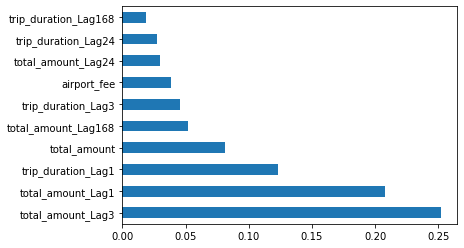

In [16]:
#1.Select the top n features based on feature importance from random forest
np.random.seed(10)

# define the model
model = RandomForestRegressor(random_state = random.seed(10))
# fit the model
model.fit(predictors, Target)

# get importance
features = predictors
importances = model.feature_importances_
indices = np.argsort(importances)

feat_importances = pd.Series(model.feature_importances_, index=predictors.columns)
feat_importances.nlargest(10).plot(kind='barh')

In [17]:
#Final Features from Random Forest (Select Features with highest feature importance)
rf_top_features = pd.DataFrame(feat_importances.nlargest(20)).axes[0].tolist()

In [18]:
#2.Select the top n features based on absolute correlation with target variable
corr_data = pd.concat([Target,predictors],axis = 1)
corr_data = corr_data.corr()
corr_data = corr_data.iloc[: , [0]]
corr_data.columns.values[0] = "Correlation"
corr_data = corr_data.iloc[corr_data.Correlation.abs().argsort()] 
corr_data = corr_data[corr_data['Correlation'].notna()]
corr_data = corr_data.loc[corr_data['Correlation'] != 1]
corr_data.sort_values(by='Correlation', ascending=False).head(10)

,Correlation
total_amount_Lag1,0.620694
total_amount,0.620503
total_amount_Lag168,0.586980
RatecodeID_Lag1,0.565804
total_amount_Lag24,0.559299
RatecodeID,0.540173
RatecodeID_Lag168,0.527980
RatecodeID_Lag24,0.513915
trip_duration_Lag3,0.501874
RatecodeID_Lag3,0.493098


In [19]:
# Select Features with greater than 70% absolute correlation
corr_data2 = corr_data.loc[corr_data['Correlation'].abs() > .5]
corr_top_features = corr_data2.axes[0].tolist()

In [20]:
#3.Select the features identified by Lasso regression
np.random.seed(10)

estimator = LassoCV(cv=5, normalize = True)

sfm = SelectFromModel(estimator, prefit=False, norm_order=1, max_features=None)

sfm.fit(predictors, Target)

feature_idx = sfm.get_support()
Lasso_features = predictors.columns[feature_idx].tolist()

In [21]:
#4.Perform recursive feature selection and use cross validation to identify the best number of features

#Feature ranking with recursive feature elimination and cross-validated selection of the best number of features
rfe_selector = RFE(estimator=LinearRegression(), n_features_to_select= 20, step=1, verbose=10)
rfe_selector.fit(predictors, Target)
rfe_support = rfe_selector.get_support()
rfe_feature = predictors.loc[:,rfe_support].columns.tolist()

Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.


In [22]:
#5.Select the top n features based on absolute value of beta coefficients of features

# define standard scaler
scaler = StandardScaler()
# transform x data
scaled_predictors = scaler.fit_transform(predictors)
scaled_Target = scaler.fit_transform(Target)

sr_reg = LinearRegression(fit_intercept = False).fit(scaled_predictors, scaled_Target)
coef_table = pd.DataFrame(list(predictors.columns)).copy()
coef_table.insert(len(coef_table.columns),"Coefs",sr_reg.coef_.transpose())
coef_table = coef_table.iloc[coef_table.Coefs.abs().argsort()] 

sr_top_features = coef_table.iloc[:,0].tolist()

In [23]:
# Combining features from all the models
combined_feature_list = sr_top_features + Lasso_features + corr_top_features + rf_top_features + rfe_feature

combined_feature = {x:combined_feature_list.count(x) for x in combined_feature_list}
combined_feature_data = pd.DataFrame.from_dict(combined_feature,orient='index')

combined_feature_data.rename(columns={ combined_feature_data.columns[0]: "number_of_models" }, inplace = True)

combined_feature_data = combined_feature_data.sort_values(['number_of_models'], ascending=[False])

combined_feature_data.head(20)

,number_of_models
total_amount_Lag24,4
RatecodeID_Lag168,4
total_amount_Lag1,4
airport_fee_Lag1,4
airport_fee_Lag24,4
total_amount_Lag168,4
total_amount,4
RatecodeID_Lag1,4
airport_fee,4
airport_fee_Lag168,4


In [24]:
#Final Features: features which were selected in atleast 3 models
combined_feature_data = combined_feature_data.loc[combined_feature_data['number_of_models'] > 3]
final_features = combined_feature_data.axes[0].tolist()
final_features

['total_amount_Lag24',
 'RatecodeID_Lag168',
 'total_amount_Lag1',
 'airport_fee_Lag1',
 'airport_fee_Lag24',
 'total_amount_Lag168',
 'total_amount',
 'RatecodeID_Lag1',
 'airport_fee',
 'airport_fee_Lag168',
 'trip_duration_Lag3',
 'airport_fee_Lag3',
 'RatecodeID_Lag24']

In [25]:
# Final Master Data on Selected Features
features = predictors[predictors.columns.intersection(final_features)]
features_date =  df2.iloc[168:,-1]
features_final = features.set_index(features_date)
features_final.head(10)

,total_amount,airport_fee,total_amount_Lag1,airport_fee_Lag1,RatecodeID_Lag1,airport_fee_Lag3,trip_duration_Lag3,total_amount_Lag24,airport_fee_Lag24,RatecodeID_Lag24,total_amount_Lag168,airport_fee_Lag168,RatecodeID_Lag168
pickup_time,,,,,,,,,,,,,
2022-01-08 00:00:00,50.781069,1.163522,53.125542,1.189759,1.0,1.208054,1675.000000,51.361316,1.184211,1.0,53.578204,1.220060,1.0
2022-01-08 01:00:00,45.585857,1.214286,50.781069,1.163522,1.0,1.164021,1746.867725,53.717576,1.250000,1.0,54.111359,1.189320,1.0
2022-01-08 02:00:00,47.696226,1.108491,45.585857,1.214286,1.0,1.189759,1665.590361,39.392500,1.250000,1.0,46.714783,1.222826,1.0
2022-01-08 03:00:00,44.716000,1.125000,47.696226,1.108491,1.0,1.163522,1554.811321,38.555000,1.250000,1.0,46.470294,1.213235,1.0
2022-01-08 04:00:00,30.252500,1.250000,44.716000,1.125000,1.0,1.214286,1414.992857,39.522857,1.071429,1.0,51.236429,0.982143,1.0
2022-01-08 05:00:00,56.537347,1.122449,30.252500,1.250000,1.0,1.108491,1343.245283,48.049643,1.250000,1.0,59.016098,1.219512,1.0
2022-01-08 06:00:00,57.799107,1.171875,56.537347,1.122449,1.0,1.125000,1520.750000,53.629818,1.227273,1.0,58.403387,1.168033,2.0
2022-01-08 07:00:00,56.088902,1.157407,57.799107,1.171875,1.0,1.250000,945.000000,52.868780,1.158537,1.0,53.367600,1.216667,1.0
2022-01-08 08:00:00,58.085306,1.211340,56.088902,1.157407,2.0,1.122449,1584.857143,52.937708,1.184896,1.0,59.468737,1.171053,2.0


In [26]:
# Final Target Variable Dataset
target_final = pd.Series(df_series['trips'], index= df_series.index).iloc[168:,]
target_final.tail(5)

pickup_time
2022-06-30 19:00:00    269
2022-06-30 20:00:00    310
2022-06-30 21:00:00    374
2022-06-30 22:00:00    338
2022-06-30 23:00:00    267
Name: trips, dtype: int64

In [27]:
features_final.tail()

,total_amount,airport_fee,total_amount_Lag1,airport_fee_Lag1,RatecodeID_Lag1,airport_fee_Lag3,trip_duration_Lag3,total_amount_Lag24,airport_fee_Lag24,RatecodeID_Lag24,total_amount_Lag168,airport_fee_Lag168,RatecodeID_Lag168
pickup_time,,,,,,,,,,,,,
2022-06-30 19:00:00,61.643086,1.184944,60.564038,1.165865,1.0,1.200980,3288.192737,61.268679,1.186909,2.0,67.572234,1.159759,2.0
2022-06-30 20:00:00,58.860839,1.193182,61.643086,1.184944,2.0,1.197581,3351.394231,59.233865,1.191950,2.0,60.099526,1.180556,2.0
2022-06-30 21:00:00,60.327754,1.202957,58.860839,1.193182,2.0,1.165865,2837.076923,59.878709,1.212349,2.0,59.049942,1.195494,2.0
2022-06-30 22:00:00,57.951391,1.194527,60.327754,1.202957,2.0,1.184944,2500.033457,58.603613,1.199422,2.0,58.937138,1.172601,2.0
2022-06-30 23:00:00,57.517715,1.193609,57.951391,1.194527,2.0,1.193182,2283.764516,58.501615,1.211340,2.0,59.526502,1.174645,2.0


In [28]:
# Data Prep
AI_Model_data = pd.concat([Target, features_final], axis=1, sort=False)

# Check stationarity

# ADF Test on each column
for name, column in AI_Model_data.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "trips" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.265
 No. Lags Chosen       = 30
 Critical value 1%     = -3.432
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "total_amount" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.1234
 No. Lags Chosen       = 31
 Critical value 1%     = -3.432
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "airport_fee" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance

In [29]:
x = AI_Model_data.values #returns a numpy array

# Standardise Datasets
standard_scaler = StandardScaler()
x_scaled = standard_scaler.fit_transform(x)
scaled_AI_Model_data = pd.DataFrame(x_scaled)
scaled_AI_Model_data.columns = AI_Model_data.columns
scaled_AI_Model_data.index = AI_Model_data.index

In [30]:
# Separate out target and features
scaled_AI_Model_Target = scaled_AI_Model_data.iloc[:,0]
scaled_AI_Model_Features = scaled_AI_Model_data.iloc[:,1:]

#Mean and Standard Deviation
mean_target = AI_Model_data.iloc[:,0].mean()
std_target = AI_Model_data.iloc[:,0].std()

scaled_AI_Model_Features

,total_amount,airport_fee,total_amount_Lag1,airport_fee_Lag1,RatecodeID_Lag1,airport_fee_Lag3,trip_duration_Lag3,total_amount_Lag24,airport_fee_Lag24,RatecodeID_Lag24,total_amount_Lag168,airport_fee_Lag168,RatecodeID_Lag168
pickup_time,,,,,,,,,,,,,
2022-01-08 00:00:00,-1.314351,-0.716758,-0.918413,0.044482,-1.478084,0.575399,-0.873944,-1.206917,-0.115810,-1.469900,-0.822973,0.899060,-1.428571
2022-01-08 01:00:00,-2.191135,0.756045,-1.314046,-0.716733,-1.478084,-0.702023,-0.776528,-0.810855,1.786561,-1.469900,-0.732963,0.036778,-1.428571
2022-01-08 02:00:00,-1.834973,-2.313380,-2.190744,0.756074,-1.478084,0.044655,-0.886698,-3.218750,1.786561,-1.469900,-1.981684,0.976656,-1.428571
2022-01-08 03:00:00,-2.337939,-1.834393,-1.834617,-2.313359,-1.478084,-0.716504,-1.036857,-3.359525,1.786561,-1.469900,-2.022960,0.707622,-1.428571
2022-01-08 04:00:00,-4.778910,1.792221,-2.337534,-1.834371,-1.478084,0.756196,-1.226379,-3.196838,-3.377017,-1.469900,-1.218321,-5.774813,-1.428571
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-30 19:00:00,0.518806,-0.095236,0.336842,-0.648744,-1.478084,0.370197,1.312708,0.458406,-0.037795,0.680318,1.539557,-0.792446,0.700000
2022-06-30 20:00:00,0.049252,0.143760,0.518933,-0.095210,0.676551,0.271567,1.398376,0.116375,0.107999,0.680318,0.277984,-0.209086,0.700000
2022-06-30 21:00:00,0.296820,0.427366,0.049425,0.143787,0.676551,-0.648520,0.701229,0.224767,0.697855,0.680318,0.100789,0.209961,0.700000


In [31]:
# Train Test Split

nobs = 24
features_train, features_test = scaled_AI_Model_Features[0:-nobs], scaled_AI_Model_Features[-nobs:]
target_train, target_test = scaled_AI_Model_Target[0:-nobs], scaled_AI_Model_Target[-nobs:]

# Check size
print(features_train.shape) 
print(features_test.shape) 
print(target_train.shape)  
print(target_test.shape)

(4148, 13)
(24, 13)
(4148,)
(24,)


In [34]:
alphas = [0.001, 0.01, 0.1, 0.25, 0.5, 0.75, 1]
l1_ratios = [.1, .25, .5, .75, 1]
regr = ElasticNetCV(alphas=alphas, l1_ratio=l1_ratios, cv=5)
regr.fit(features_train,target_train)
y_pred_EN = regr.predict(features_test)

In [35]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [50, 75, 100],
    'max_features': [5, 7],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [5, 10],
    'n_estimators': [100, 500, 1000]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid,  cv = 5, n_jobs = -1, verbose = 2)
grid_search.fit(features_train,target_train)
y_pred_rf=grid_search.predict(features_test)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


In [36]:
xgbr = xgb.XGBRegressor()
parameters = {'nthread':[4],
              'objective':['reg:squarederror'],
              'learning_rate': [.025, 0.05, .075],
              'max_depth': [5, 6, 7],
              'min_child_weight': [5,6,7],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.5],
              'booster':['gbtree'],
              'max_delta_step': [0,5],
              'n_estimators': [1000]}


xgb_grid = GridSearchCV(xgbr,
                        parameters,
                        cv = 5,
                        n_jobs = 5,
                        verbose=True, return_train_score=False, refit=True,
                        scoring = 'neg_root_mean_squared_error')

xgb_grid.fit(features_train, target_train)
y_pred_xgb=xgb_grid.predict(features_test)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[16:20:35] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [37]:
# SVR
svr = SVR(kernel='rbf')
parameters = {'C': [1, 5, 10, 50, 100],
              'epsilon': [0.001, 0.01, 1],
              'gamma': [0.025, 0.05, 0.075, 0.1, 0.5, 1]}


svr_grid = GridSearchCV(svr,
                        parameters,
                        cv = 5,
                        n_jobs = 5,
                        verbose=True, return_train_score=False, refit=True,
                        scoring = 'neg_root_mean_squared_error')

svr_grid.fit(features_train, target_train)
y_pred_svr=svr_grid.predict(features_test)

Fitting 5 folds for each of 90 candidates, totalling 450 fits


In [38]:
# Holt Winter’s Exponential Smoothing (HWES)or Triple Smoothing
# fit model

random.seed(10)

model = ExponentialSmoothing(target_train,seasonal= 'add', seasonal_periods= 24)
model_fit = model.fit()
# make prediction
y_pred_hwes = model_fit.forecast(steps=24).values

In [39]:
# Data Prep for VAR/VECM - First Difference and check stationarity

# Data Prep for VAR - check stationarity
varma_vecm_data = pd.concat([target_train, features_train], axis=1, sort=False)
varma_vecm_data  = varma_vecm_data[varma_vecm_data.columns.drop(list(varma_vecm_data.filter(regex='Lag')))]

# 1st difference
varma_vecm_data_differenced = varma_vecm_data.diff(periods=24).dropna()

In [40]:
#VAR Model

model = VAR(varma_vecm_data_differenced)
lag_selection_VAR = model.select_order(maxlags=3)

list(lag_selection_VAR.selected_orders.values())[0]


# Get the lag order
lag_order = list(lag_selection_VAR.selected_orders.values())[0]

model_fitted = model.fit(lag_order)


# Input data for forecasting
forecast_input = varma_vecm_data_differenced.values[-lag_order:]

# Forecast
y_pred_VAR = model_fitted.forecast(y=forecast_input, steps= 24)


#VAR Forecast

def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

y_pred_VAR = invert_transformation(varma_vecm_data, pd.DataFrame(y_pred_VAR , index= features_test.index, columns=varma_vecm_data_differenced.columns + '_1d'), second_diff=False)['trips_forecast']

In [41]:
# VECM - Johansen Cointegration Test'
rank_test = select_coint_rank(varma_vecm_data_differenced,-1, lag_order, method='trace',
                              signif=0.05)
print(rank_test)

Johansen cointegration test using trace test statistic with 5% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   3          1875.          24.28
  1   3          935.2          12.32
  2   3          335.7          4.130
-------------------------------------


In [42]:
# VECM

model = VECM(varma_vecm_data_differenced, deterministic="ci",
             k_ar_diff=lag_order,  
             coint_rank=rank_test.rank)  

vecm_res = model.fit()

y_pred_VECM = vecm_res.predict(steps=24)

y_pred_VECM = invert_transformation(varma_vecm_data, pd.DataFrame(y_pred_VAR , index= features_test.index, columns=varma_vecm_data_differenced.columns + '_1d'), second_diff=False)['trips_forecast']

In [43]:
stepwise_fit = pm.auto_arima(target_train, m=1, seasonal=False, trace=True,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)  # set to stepwise
y_pred_arima = stepwise_fit.predict(n_periods= 24)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=3.50 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6791.374, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6754.756, Time=0.20 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6761.370, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6789.375, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=6722.112, Time=0.21 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=6659.614, Time=0.44 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=6482.370, Time=0.60 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=6421.332, Time=0.62 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=6423.201, Time=1.92 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=6442.161, Time=1.07 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=6419.335, Time=0.32 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=6480.372, Time=0.27 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=6421.204, Time=0.62 sec
 ARIMA(4,1,1)(0,0,0)[0]             : 

In [ ]:
plot_pacf(target_final, lags =24)

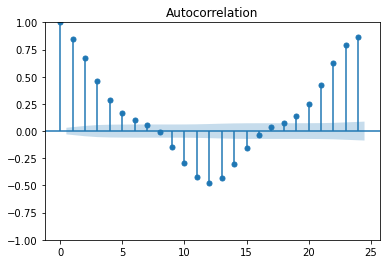

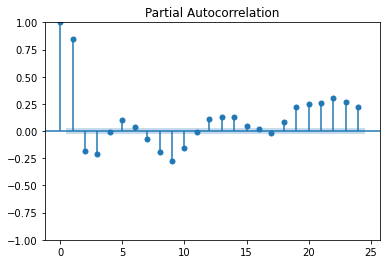

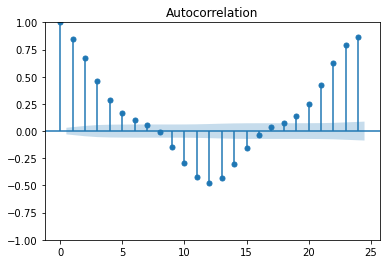

In [59]:
plot_acf(target_final, lags =24)

In [71]:
sarima_model=SARIMAX(target_train,order=stepwise_fit.order,seasonal_order=(1,1,0,24)).fit()
y_pred_sarima=sarima_model.predict(len(target_train),len(target_train)+23, dynamic= True).values  

In [69]:
model = SARIMAX(target_train, exog=features_train, order=stepwise_fit.order, seasonal_order=(1,1,0,24)).fit(disp=False)
y_pred_sarimax = model.predict(len(target_train),len(target_train)+23, exog=features_test).values 

In [32]:
train_X = features_train.to_numpy().reshape((features_train.shape[0], 1, features_train.shape[1]))
test_X = features_test.to_numpy().reshape((features_test.shape[0], 1, features_test.shape[1]))
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
# fit network
history = model.fit(train_X, target_train, epochs=50, batch_size=32, verbose=2, shuffle=False)
y_pred_LSTM = model.predict(test_X)

NotImplementedError: Cannot convert a symbolic Tensor (lstm/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported

In [72]:
predictions=pd.DataFrame()
predictions['Actual Values']=target_test
predictions['ElasticNet']=y_pred_EN
predictions['RandomForest']=y_pred_rf
predictions['XGBoost']=y_pred_xgb
predictions['SVR']=y_pred_svr
predictions['HWES']=y_pred_hwes
predictions['VAR (1st difference)']=y_pred_VAR
predictions['VECM (1st difference)']=y_pred_VECM
predictions['ARIMA']=y_pred_arima.values
predictions['SARIMA']=y_pred_sarima
predictions['SARIMAX (with exog)']=y_pred_sarimax
predictions['LSTM']=y_pred_LSTM
predictions=(predictions*std_target)+ mean_target
predictions

,Actual Values,ElasticNet,RandomForest,XGBoost,SVR,HWES,VAR (1st difference),VECM (1st difference),ARIMA,SARIMA,SARIMAX (with exog)
pickup_time,,,,,,,,,,,
2022-06-30 00:00:00,151.996078,130.572454,122.655400,150.722565,111.777925,238.493812,282.556397,282.556397,287.489747,257.438349,252.872614
2022-06-30 01:00:00,144.995239,76.615502,62.439318,64.533165,69.058849,99.665703,277.233407,277.233407,277.737705,58.443926,59.900851
2022-06-30 02:00:00,54.984451,92.064038,66.413842,62.819733,61.603758,38.756607,267.042695,267.042695,278.349701,37.561116,38.064736
2022-06-30 03:00:00,30.981574,19.019760,42.180638,35.602875,30.967880,7.536555,261.961508,261.961508,286.837879,-8.786592,3.635577
2022-06-30 04:00:00,23.980735,121.185851,86.941394,44.541428,81.287840,9.516108,258.010991,258.010991,295.626527,-4.679864,-17.478247
2022-06-30 05:00:00,93.989126,85.160691,105.775531,97.239883,101.986951,69.507405,254.594827,254.594827,299.280972,58.122008,50.046161
2022-06-30 06:00:00,130.993561,149.272001,141.603151,155.651260,137.146895,142.677579,252.216353,252.216353,300.749281,111.506270,120.753780
2022-06-30 07:00:00,181.999674,189.874059,149.729529,118.997887,86.849731,166.913470,250.413944,250.413944,298.697792,138.403475,140.132066
2022-06-30 08:00:00,120.992362,206.174424,178.765674,182.802490,207.404318,143.759058,249.045267,249.045267,295.665923,116.404034,120.585946


In [73]:
RMSE = {}
RMSE['ElasticNet']=mean_squared_error(predictions['Actual Values'],predictions['ElasticNet'],squared=False)
RMSE['RandomForest']=mean_squared_error(predictions['Actual Values'],predictions['RandomForest'],squared=False)
RMSE['XGBoost']=mean_squared_error(predictions['Actual Values'],predictions['XGBoost'],squared=False)
RMSE['HWES']=mean_squared_error(predictions['Actual Values'],predictions['HWES'],squared=False)
RMSE['SVR']=mean_squared_error(predictions['Actual Values'],predictions['SVR'],squared=False)
RMSE['VAR (1st difference)']=mean_squared_error(predictions['Actual Values'],predictions['VAR (1st difference)'],squared=False)
RMSE['VECM (1st difference)']=mean_squared_error(predictions['Actual Values'],predictions['VECM (1st difference)'],squared=False)
RMSE['ARIMA']=mean_squared_error(predictions['Actual Values'],predictions['ARIMA'],squared=False)
RMSE['SARIMA']=mean_squared_error(predictions['Actual Values'],predictions['SARIMA'],squared=False)
RMSE['SARIMAX (with exog)']=mean_squared_error(predictions['Actual Values'],predictions['SARIMAX (with exog)'],squared=False)
RMSE['LSTM']=mean_squared_error(predictions['Actual Values'],predictions['LSTM'],squared=False)
RMSE = {'MODELS': list(RMSE.keys()), 'RMSE': list(RMSE.values())}

In [74]:
fig = px.bar(RMSE, x='MODELS', y='RMSE')
fig.update_layout({
'plot_bgcolor': 'rgba(0, 0, 0, 0)',
'paper_bgcolor': 'rgba(0, 0, 0, 0)',
})
fig.update_yaxes(automargin=True)
fig.update_xaxes(automargin=True)
fig.show()

In [78]:
fig = go.Figure()
fig.add_trace(go.Scatter(x = predictions.index, y = predictions['Actual Values'], name = 'Actual Values', line=dict(width=5)))
for column in [
    'ElasticNet','RandomForest','XGBoost','SVR',
    #'HWES','VAR (1st difference)','VECM (1st difference)','ARIMA', 'SARIMA', 'SARIMAX (with exog)'
]:
    fig.add_trace(
        go.Scatter(
            x = predictions.index,
            y = predictions[column],
            name = column,line=dict(width=3,  dash='dash')
        )
    )
fig.update_layout({
'plot_bgcolor': 'rgba(0, 0, 0, 0)',
'paper_bgcolor': 'rgba(0, 0, 0, 0)',
})
fig.update_yaxes(automargin=True)
fig.update_xaxes(automargin=True)
fig.show()

In [76]:
fig = go.Figure()
fig.add_trace(go.Scatter(x = predictions.index, y = predictions['Actual Values'], name = 'Actual Values', line=dict(width=5)))
for column in [
    #'ElasticNet','RandomForest','XGBoost','SVR',
    'HWES','VAR (1st difference)','VECM (1st difference)','ARIMA', 'SARIMA', 'SARIMAX (with exog)']:
    fig.add_trace(
        go.Scatter(
            x = predictions.index,
            y = predictions[column],
            name = column,line=dict(width=3,  dash='dash')
        )
    )
fig.update_layout({
'plot_bgcolor': 'rgba(0, 0, 0, 0)',
'paper_bgcolor': 'rgba(0, 0, 0, 0)',
})
fig.update_yaxes(automargin=True)
fig.update_xaxes(automargin=True)
fig.show()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x = predictions.index, y = predictions['Actual Values'], name = 'Actual Values', line=dict(width=5)))
for column in [
    'LSTM','XGBoost','HWES', 'SARIMAX (with exog)'
]:
    fig.add_trace(
        go.Scatter(
            x = predictions.index,
            y = predictions[column],
            name = column,line=dict(width=3,  dash='dash')
        )
    )
fig.update_layout({
'plot_bgcolor': 'rgba(0, 0, 0, 0)',
'paper_bgcolor': 'rgba(0, 0, 0, 0)',
})
fig.update_yaxes(automargin=True)
fig.update_xaxes(automargin=True)
fig.show()

In [77]:
RMSE

{'MODELS': ['ElasticNet',
  'RandomForest',
  'XGBoost',
  'HWES',
  'SVR',
  'VAR (1st difference)',
  'VECM (1st difference)',
  'ARIMA',
  'SARIMA',
  'SARIMAX (with exog)'],
 'RMSE': [70.03907075093473,
  51.38759569812878,
  47.66909007188188,
  28.147386761849045,
  56.415458256742625,
  122.1858848834096,
  122.1858848834096,
  139.05630098179813,
  44.26765676185896,
  43.11882402667035]}